<a href="https://colab.research.google.com/github/667029/dat158-ML-assignment2/blob/main/ML_Assignm2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#HEI

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sklearn

In [2]:
seed = 42
np.random.seed(seed)

In [3]:
train_url = "https://raw.githubusercontent.com/667029/dat158-ML-assignment2/refs/heads/main/df_train.csv"
test_url = "https://raw.githubusercontent.com/667029/dat158-ML-assignment2/refs/heads/main/df_test.csv"

train_data = pd.read_csv(train_url)
test_data = pd.read_csv(test_url)

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14105 entries, 0 to 14104
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               14105 non-null  object 
 1   price              14105 non-null  float64
 2   bedrooms           14105 non-null  int64  
 3   grade              14105 non-null  int64  
 4   has_basement       14105 non-null  bool   
 5   living_in_m2       14105 non-null  float64
 6   renovated          14105 non-null  bool   
 7   nice_view          14105 non-null  bool   
 8   perfect_condition  14105 non-null  bool   
 9   real_bathrooms     14105 non-null  int64  
 10  has_lavatory       14105 non-null  bool   
 11  single_floor       14105 non-null  bool   
 12  month              14105 non-null  int64  
 13  quartile_zone      14105 non-null  int64  
dtypes: bool(6), float64(2), int64(5), object(1)
memory usage: 964.3+ KB


In [5]:
train_data.drop("date", axis=1, inplace=True)
test_data.drop("date", axis=1, inplace=True)

In [6]:
# Liste over boolske kolonner
bool_columns = ["has_basement", "renovated", "nice_view", "perfect_condition", "has_lavatory", "single_floor"]

# Endrer dem til int verdier 0/1
train_data[bool_columns] = train_data[bool_columns].astype(int)
test_data[bool_columns] = test_data[bool_columns].astype(int)

In [7]:
manglende_verdier = train_data.isnull().sum()
print("Manglende verdier", manglende_verdier)

Manglende verdier price                0
bedrooms             0
grade                0
has_basement         0
living_in_m2         0
renovated            0
nice_view            0
perfect_condition    0
real_bathrooms       0
has_lavatory         0
single_floor         0
month                0
quartile_zone        0
dtype: int64


array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'bedrooms'}>,
        <Axes: title={'center': 'grade'}>,
        <Axes: title={'center': 'has_basement'}>],
       [<Axes: title={'center': 'living_in_m2'}>,
        <Axes: title={'center': 'renovated'}>,
        <Axes: title={'center': 'nice_view'}>,
        <Axes: title={'center': 'perfect_condition'}>],
       [<Axes: title={'center': 'real_bathrooms'}>,
        <Axes: title={'center': 'has_lavatory'}>,
        <Axes: title={'center': 'single_floor'}>,
        <Axes: title={'center': 'month'}>],
       [<Axes: title={'center': 'quartile_zone'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

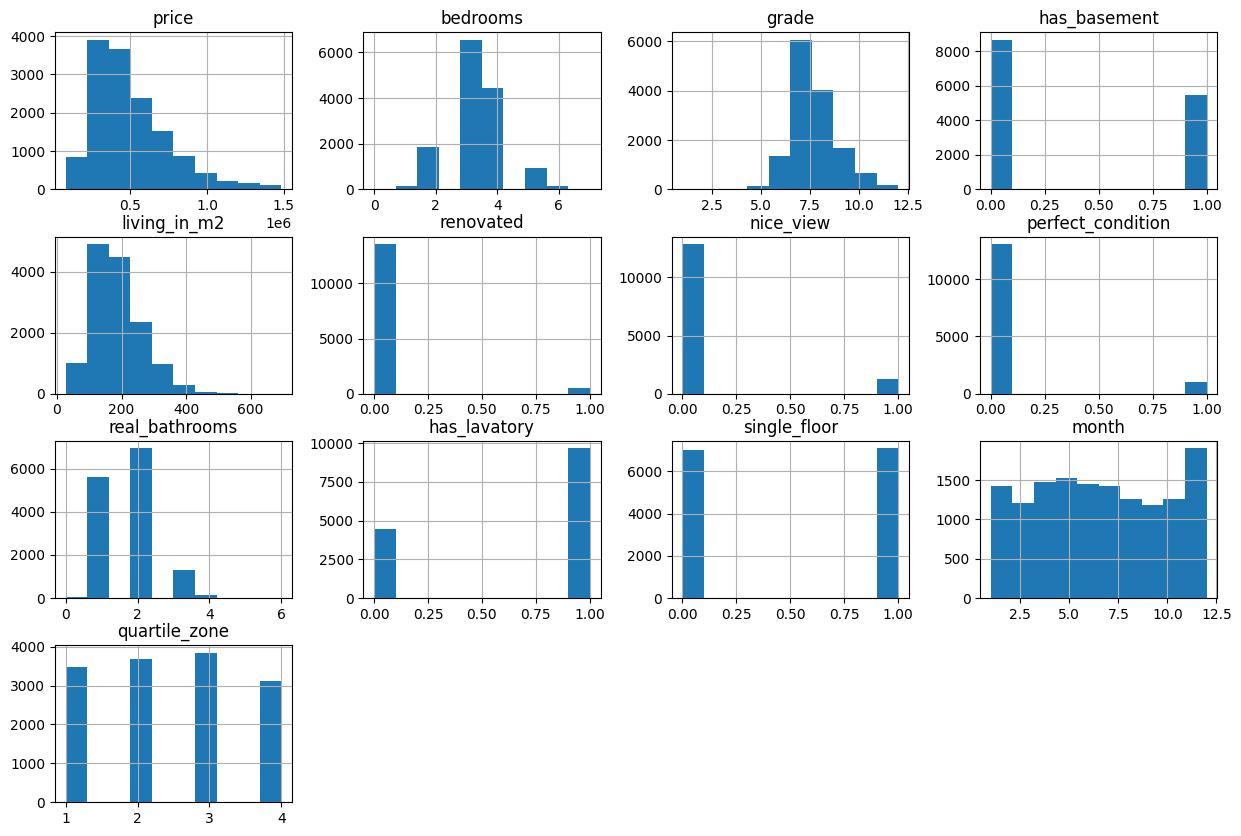

In [8]:
train_data.hist(figsize=(15, 10))

<Axes: >

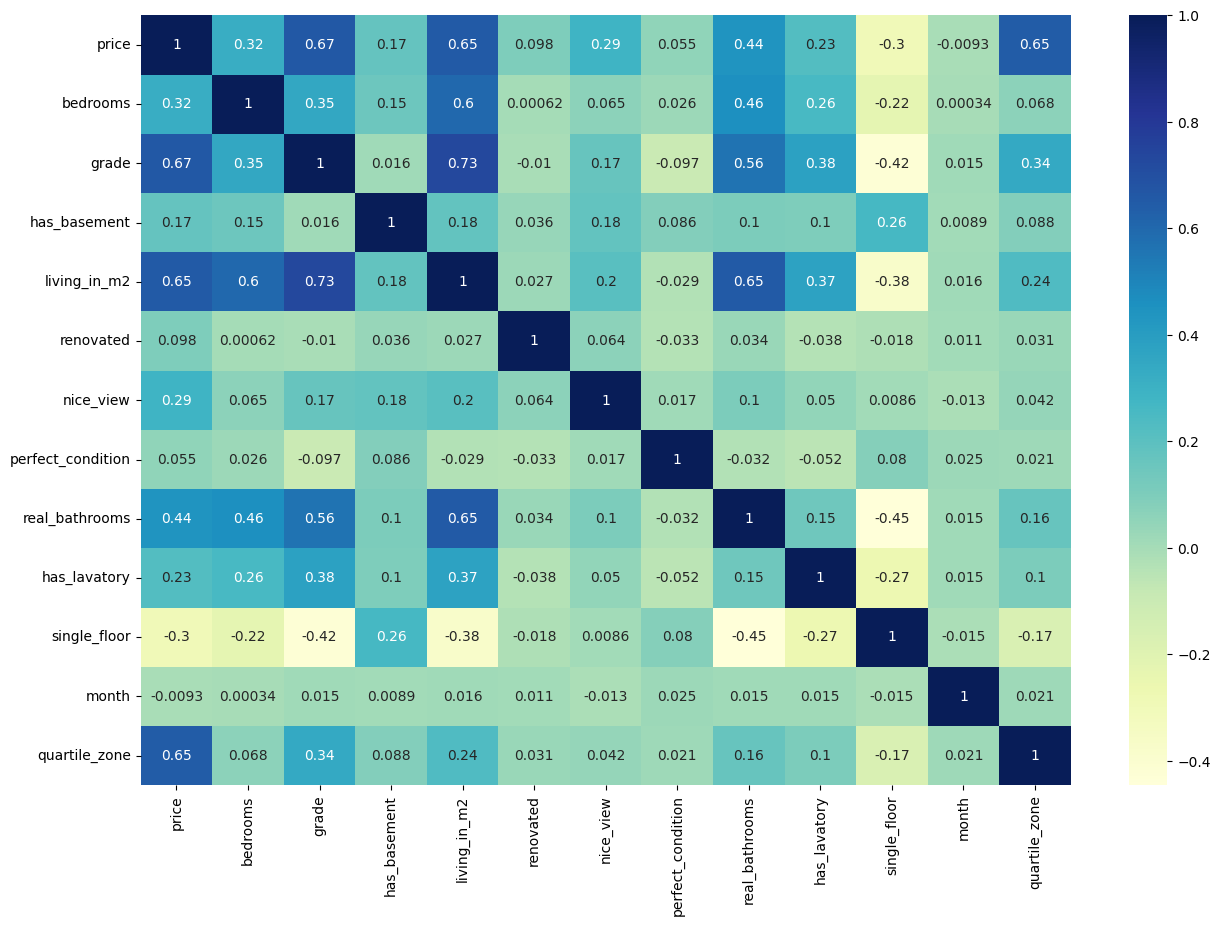

In [9]:
plt.figure(figsize=(15, 10))
sns.heatmap(train_data.corr(), annot=True, cmap = "YlGnBu")

In [10]:
#Log-transformerer data som er skevt fordelt

train_data['price'] = np.log1p(train_data['price'])
train_data['living_in_m2'] = np.log1p(train_data['living_in_m2'])
train_data['real_bathrooms'] = np.log1p(train_data['real_bathrooms'])

array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'bedrooms'}>,
        <Axes: title={'center': 'grade'}>,
        <Axes: title={'center': 'has_basement'}>],
       [<Axes: title={'center': 'living_in_m2'}>,
        <Axes: title={'center': 'renovated'}>,
        <Axes: title={'center': 'nice_view'}>,
        <Axes: title={'center': 'perfect_condition'}>],
       [<Axes: title={'center': 'real_bathrooms'}>,
        <Axes: title={'center': 'has_lavatory'}>,
        <Axes: title={'center': 'single_floor'}>,
        <Axes: title={'center': 'month'}>],
       [<Axes: title={'center': 'quartile_zone'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

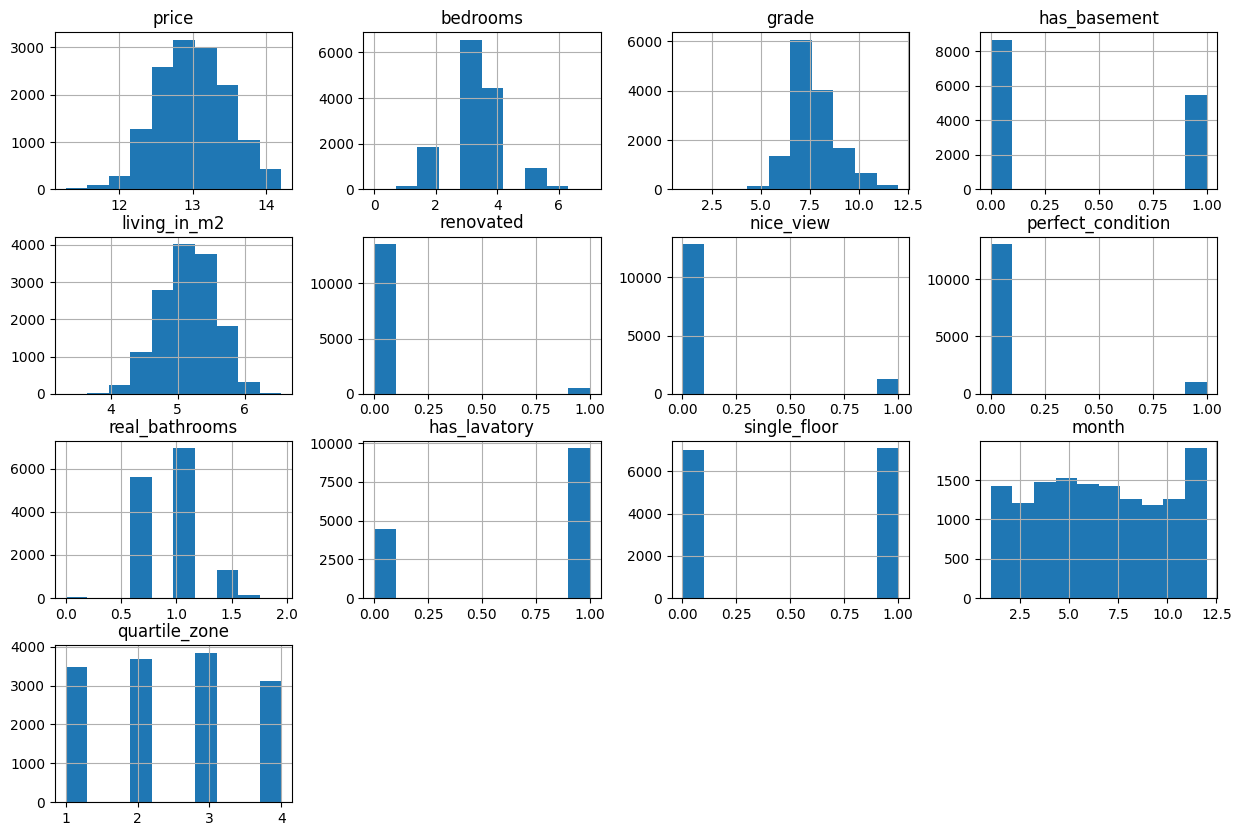

In [11]:
train_data.hist(figsize=(15, 10))

In [12]:
#transformerer month om til sykliske variabler for å gjennkjenne sesongbaserte aktiviteter
data = pd.DataFrame({
    'month': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
})

train_data['month_sin'] = np.sin(2*np.pi*train_data['month']/12)
train_data['month_cos'] = np.cos(2*np.pi*train_data['month']/12)

train_data.drop('month', axis=1, inplace=True)

# Feature Engineering

Her vi tidligere beregnet 'price_per_m2' og 'price_to_quartile_ratio', noe som viste seg å være idiotisk siden begge disse nye veriablene inneholder målvariablen.
Dette medfører både datalekkasje, noe som mulig kan forklare hvorfor modellen presterte mye bedre enn forventet, og det vil være umulig for bruker å fylle inne disse dataene gjennom grensesnittet.

In [13]:
train_data['space_quality'] = train_data['living_in_m2']/train_data['grade']
train_data['bathroom_density'] = train_data['real_bathrooms']/train_data['living_in_m2']

<Axes: >

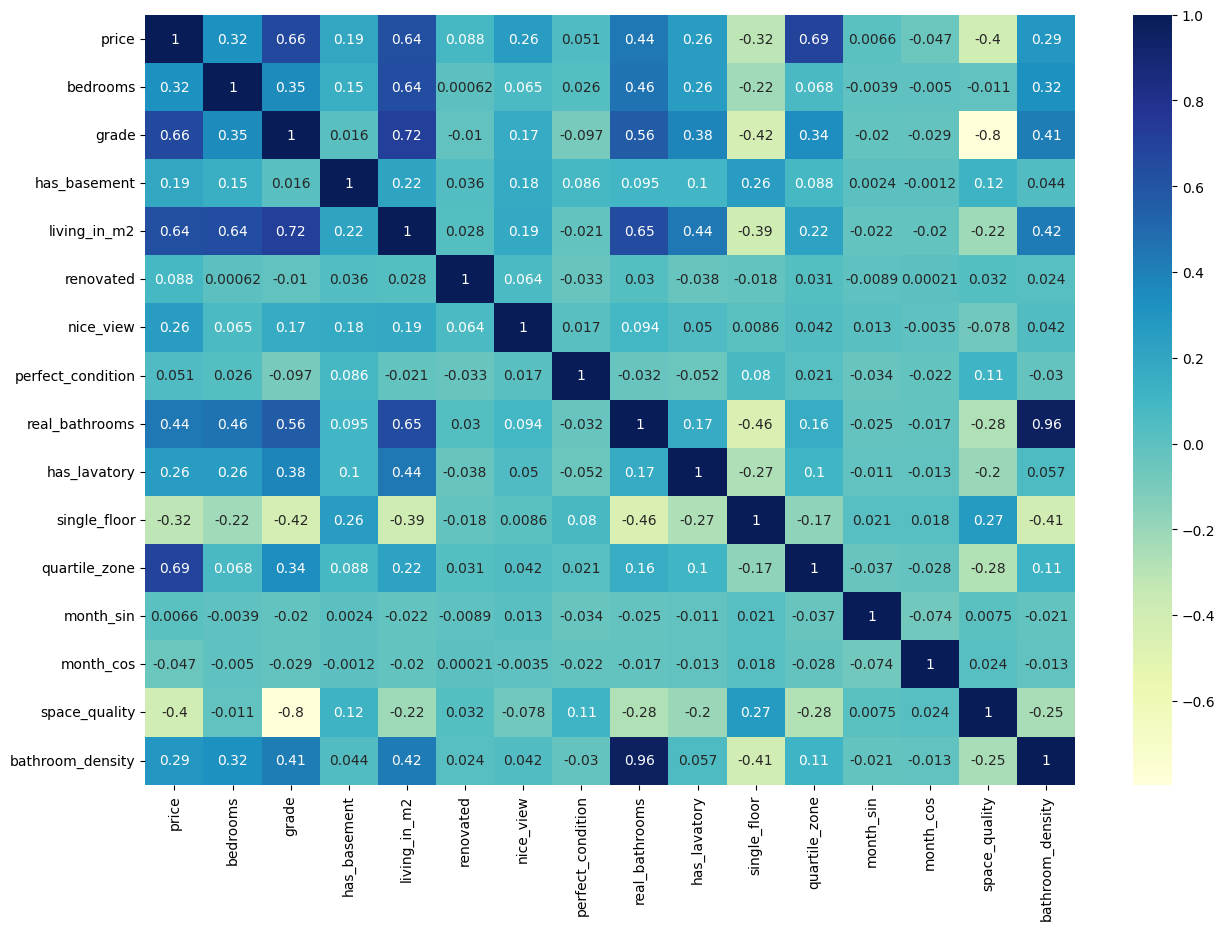

In [14]:
plt.figure(figsize=(15, 10))
sns.heatmap(train_data.corr(), annot=True, cmap = "YlGnBu")

# Splitting og bestemmelse av modell

In [15]:
from sklearn.model_selection import train_test_split
X = train_data.drop('price', axis=1)
y = train_data['price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
pip install xgboost

In [17]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(random_state=seed, n_jobs=-1)

from xgboost import XGBRegressor
model_XGBR = XGBRegressor(random_state=seed, n_jobs=-1)

from sklearn.ensemble import GradientBoostingRegressor
model_GBR = GradientBoostingRegressor()

In [18]:
rf_reg.fit(X_train, y_train)
model_XGBR.fit(X_train, y_train)
model_GBR.fit(X_train, y_train)

GradientBoostingRegressor()

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

XGBR_predictions = model_XGBR.predict(X_val)
GBR_predictions = model_GBR.predict(X_val)
RF_predictions = rf_reg.predict(X_val)

XGBR_mae = mean_absolute_error(y_val, XGBR_predictions)
XGBR_rmse = np.sqrt(mean_squared_error(y_val, XGBR_predictions))

GBR_mae = mean_absolute_error(y_val, GBR_predictions)
GBR_rmse = np.sqrt(mean_squared_error(y_val, GBR_predictions))

RF_mae = mean_absolute_error(y_val, RF_predictions)
RF_rmse = np.sqrt(mean_squared_error(y_val, RF_predictions))

print ("RandomForestR. - MAE: ", RF_mae, "RMSE: ", RF_rmse)
print ("Gradient Boosting. - MAE: ", GBR_mae, "RMSE: ", GBR_rmse)
print("XGBoost - MAE: ", XGBR_mae, "RMSE: ", XGBR_rmse)

RandomForestR. - MAE:  0.1737628728724907 RMSE:  0.22922737814736557
Gradient Boosting. - MAE:  0.16408738447275928 RMSE:  0.21452815206065756
XGBoost - MAE:  0.1691507411368748 RMSE:  0.22223541245716805


**Som vi Ser presterer Gradient Boosting-modellen best, men finner senere ut at Random forest presterer bedre etter optimalisering så velger den.**

MAE(Mean Absolute Error) og RMSE(Root Mean Sqaured Error) er to vanlig metrikker for å evaluere regresjonsmodeller.
- **MAE**: Gjennomsnittet av de absolutte feilene mellom prediksjoner og faktiske verdier. Den måler hvor mye modellen bommer i gjennomsnitt.
- **RMSE**: Kvadratroten av gjennomsnittet av de kvadrerte feilene. Derfor straffes større feil hardere enn MAE, altså avvikene. Dette fordi          feilene kvadreres.

**MAE** gir direkte måling av gjennomsnittlig feil, mens **RMSE** straffer store feil mer og gir indikator på store avvik.


In [20]:
#from sklearn.model_selection import GridSearchCV
#rf_model = RandomForestRegressor(random_state=seed, n_jobs=-1)

#param_grid = {
 #   "n_estimators": [100, 200, 300, 500],  # Økt antall trær
 #   "max_features": ["sqrt", "log2", 2, 4, 6, 8],  # Inkluderer både numeriske og standard verdier
 #   "max_depth": [3, 5, 7, 10],  # Legger til max_depth for å kontrollere treets dybde
#    "min_samples_split": [8, 10, 12],  # Minimum antall prøver for splitting
#    "min_samples_leaf": [3, 4, 5]  # Minimum antall prøver per bladnode
#}

#grid_search = GridSearchCV(rf_reg, param_grid, cv = 5, scoring='neg_mean_squared_error', n_jobs=-1)
#grid_search.fit(X_train, y_train)

#print("beste parametre: ", grid_search.best_params_)
#print("beste score: ", grid_search.best_score_)

In [21]:
best_model = RandomForestRegressor(
    random_state=seed,
    n_jobs=-1,
    max_features= 20,
    n_estimators=500,
    max_depth=None,
    min_samples_split=8,
    min_samples_leaf=3,
    bootstrap=True,
)
best_model.fit(X_train, y_train)

RandomForestRegressor(max_features=20, min_samples_leaf=3, min_samples_split=8,
                      n_estimators=500, n_jobs=-1, random_state=42)

In [22]:
# Treningsscore
train_predictions = best_model.predict(X_train)
train_mse = mean_squared_error(y_train, train_predictions)
train_mae = mean_absolute_error(y_train, train_predictions)
train_r2 = best_model.score(X_train, y_train)

# Valideringsscore
val_predictions = best_model.predict(X_val)
val_mse = mean_squared_error(y_val, val_predictions)
val_mae = mean_absolute_error(y_val, val_predictions)
val_r2 = best_model.score(X_val, y_val)

print("Treningsscore:")
print("MSE:", train_mse)
print("MAE:", train_mae)
print("R2:", train_r2)

print("\nValideringsscore:")
print("MSE:", val_mse)
print("MAE:", val_mae)
print("R2:", val_r2)

Treningsscore:
MSE: 0.02231978311983057
MAE: 0.11130191922799298
R2: 0.9018894369051856

Valideringsscore:
MSE: 0.04948608208437939
MAE: 0.16901443858147885
R2: 0.7775918842794075


In [26]:
import joblib
# Lagre modellen
joblib.dump(best_model, "final_model.joblib")

['final_model.joblib']

# Reflekter endringer over på det urørte test_data settet

In [23]:
# Log-transformasjonene
test_data['price'] = np.log1p(test_data['price'])
test_data['living_in_m2'] = np.log1p(test_data['living_in_m2'])
test_data['real_bathrooms'] = np.log1p(test_data['real_bathrooms'])

# Syklisk transformasjon for `month`
test_data['month_sin'] = np.sin(2 * np.pi * test_data['month'] / 12)
test_data['month_cos'] = np.cos(2 * np.pi * test_data['month'] / 12)

test_data['space_quality'] = test_data['living_in_m2']/test_data['grade']
test_data['bathroom_density'] = test_data['real_bathrooms']/test_data['living_in_m2']

# Fjern `month` etter syklisk transformasjon
test_data.drop('month', axis=1, inplace=True)

**Undersøker om de fortsatt er like, og det er de!**

In [24]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14105 entries, 0 to 14104
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              14105 non-null  float64
 1   bedrooms           14105 non-null  int64  
 2   grade              14105 non-null  int64  
 3   has_basement       14105 non-null  int64  
 4   living_in_m2       14105 non-null  float64
 5   renovated          14105 non-null  int64  
 6   nice_view          14105 non-null  int64  
 7   perfect_condition  14105 non-null  int64  
 8   real_bathrooms     14105 non-null  float64
 9   has_lavatory       14105 non-null  int64  
 10  single_floor       14105 non-null  int64  
 11  quartile_zone      14105 non-null  int64  
 12  month_sin          14105 non-null  float64
 13  month_cos          14105 non-null  float64
 14  space_quality      14105 non-null  float64
 15  bathroom_density   14105 non-null  float64
dtypes: float64(7), int64(9

In [25]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6948 entries, 0 to 6947
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              6948 non-null   float64
 1   bedrooms           6948 non-null   int64  
 2   grade              6948 non-null   int64  
 3   has_basement       6948 non-null   int64  
 4   living_in_m2       6948 non-null   float64
 5   renovated          6948 non-null   int64  
 6   nice_view          6948 non-null   int64  
 7   perfect_condition  6948 non-null   int64  
 8   real_bathrooms     6948 non-null   float64
 9   has_lavatory       6948 non-null   int64  
 10  single_floor       6948 non-null   int64  
 11  quartile_zone      6948 non-null   int64  
 12  month_sin          6948 non-null   float64
 13  month_cos          6948 non-null   float64
 14  space_quality      6948 non-null   float64
 15  bathroom_density   6948 non-null   float64
dtypes: float64(7), int64(9)


In [28]:
# Fjern målvariabelen `price` fra test_data når du lager prediksjoner
X_test = test_data.drop('price', axis=1)
y_test = test_data['price']  # Dette er de faktiske verdiene vi sammenligner med

# Lag prediksjoner
test_predictions = best_model.predict(X_test)


# Sammenlign prediksjonene med de faktiske `price`-verdiene i testsettet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

test_mse = mean_squared_error(y_test, test_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

print("Test MSE:", test_mse)
print("Test MAE:", test_mae)
print("Test R²:", test_r2)

Test MSE: 0.04974187351011704
Test MAE: 0.1684424482949269
Test R²: 0.7789179170756269


In [29]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.24.7
    Uninstalling huggingface-hub-0.24.7:
      Successfully uninstalled huggingface-hub-0.24.7


In [30]:
import gradio as gr
import numpy as np
import pandas as pd
import joblib

# Last inn den lagrede modellen
best_model = joblib.load('final_model.joblib')

# Definer prediksjonsfunksjonen med nødvendige inputvariabler
def predict_price(grade, has_basement, living_in_m2, renovated, nice_view,
                  perfect_condition, real_bathrooms, has_lavatory,
                  single_floor, quartile_zone, month, bedrooms):

    # Transformasjonene som modellen forventer
    living_in_m2 = np.log1p(living_in_m2)
    real_bathrooms = np.log1p(real_bathrooms)
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)

    space_quality = living_in_m2/grade
    bathroom_density = real_bathrooms/living_in_m2

    # Lag en DataFrame for alle inputvariablene modellen krever
    input_data = pd.DataFrame({
        'bedrooms': [bedrooms],
        'grade': [grade],
        'has_basement': [has_basement],
        'living_in_m2': [living_in_m2],
        'renovated': [renovated],
        'nice_view': [nice_view],
        'perfect_condition': [perfect_condition],
        'real_bathrooms': [real_bathrooms],
        'has_lavatory': [has_lavatory],
        'single_floor': [single_floor],
        'quartile_zone': [quartile_zone],
        'month_sin': [month_sin],
        'month_cos': [month_cos],
        'space_quality': [space_quality],
        'bathroom_density': [bathroom_density]
    })

    # Prediksjon (i log-skala) og konverter til vanlig skala
    price_log = best_model.predict(input_data)[0]
    price = np.expm1(price_log)  # Konverter log-transformert pris tilbake
    return f"${price:,.2f}"  # Formaterer pris til to desimaler og med dollartegn

# Sett opp Gradio-grensesnittet
interface = gr.Interface(
    fn=predict_price,
    inputs=[
        gr.Number(label="Grade"),
        gr.Checkbox(label="Has Basement"),
        gr.Number(label="Living Area in m²"),
        gr.Checkbox(label="Renovated"),
        gr.Checkbox(label="Nice View"),
        gr.Checkbox(label="Perfect Condition"),
        gr.Number(label="Real Bathrooms"),
        gr.Checkbox(label="Has Lavatory"),
        gr.Checkbox(label="Single Floor"),
        gr.Number(label="Quartile Zone"),
        gr.Slider(1, 12, step=1, label="Month (1=Jan, 12=Dec)"),
        gr.Number(label="Bedrooms")
    ],
    outputs=gr.Textbox(label="Predicted Price"),
    title="House Price Prediction"
)

# Start Gradio-appen
interface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://bea83b71243408c706.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
